In [7]:
import os
import json
import pickle
import sys
sys.path.insert(0, '../')
from src.DataSaver import DataSaver
from src.DynamicSystemAnalyzer import *
from src.PerformanceAnalyzer import *
from src.RNN_numpy import RNN_numpy
from src.utils import get_project_root, numpify, orthonormalize
from src.Trainer import Trainer
from src.RNN_torch import RNN_torch
from src.Task import *
from matplotlib import pyplot as plt
import torch
import time
from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# from src.datajoint_config import *

In [8]:
disp = True
activation = "relu"
taskname = "ColorDiscrimination"
config_dict = json.load(open(os.path.join(get_project_root(), "data", "configs",
                                          'train_config_ColorDiscrimination_relu;N=100;lmbdr=0.5;lmbdo=0.3;lmbds=0.1.json'), mode="r"))

In [10]:
# defining RNN:
N = config_dict["N"]
activation_name = config_dict["activation"]
if activation_name == 'relu':
    activation = lambda x: torch.maximum(x, torch.tensor(0))
elif activation_name == 'tanh':
    activation = torch.tanh
elif activation_name == 'sigmoid':
    activation = lambda x: 1/(1 + torch.exp(-x))
elif activation_name == 'softplus':
    activation = lambda x: torch.log(1 + torch.exp(5 * x))

dt = config_dict["dt"]
tau = config_dict["tau"]
constrained = config_dict["constrained"]
connectivity_density_rec = config_dict["connectivity_density_rec"]
spectral_rad = config_dict["sr"]
sigma_inp = config_dict["sigma_inp"]
sigma_rec = config_dict["sigma_rec"]
seed = config_dict["seed"]
rng = torch.Generator()
if not seed is None:
    rng.manual_seed(seed)
input_size = config_dict["num_inputs"]
output_size = config_dict["num_outputs"]

In [11]:
# Task:
n_steps = config_dict["n_steps"]
task_params = config_dict["task_params"]

In [12]:
# Trainer:
lambda_orth = config_dict["lambda_orth"]
lambda_r = config_dict["lambda_r"]
mask = np.array(config_dict["mask"])
max_iter = 1000#config_dict["max_iter"]
tol = config_dict["tol"]
lr = config_dict["lr"]
weight_decay = config_dict["weight_decay"]
same_batch = config_dict["same_batch"]

In [13]:
config_dict["constrained"] = True

In [14]:
# creating instances:
rnn_torch = RNN_torch(N=N, dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                      activation=activation, constrained=constrained,
                      sigma_inp=sigma_inp, sigma_rec=sigma_rec,
                      connectivity_density_rec=connectivity_density_rec,
                      spectral_rad=spectral_rad,
                      random_generator=rng)
task = TaskColorDiscrimination(n_steps=n_steps, task_params=task_params)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rnn_torch.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)
trainer = Trainer(RNN=rnn_torch, Task=task,
                  max_iter=max_iter, tol=tol,
                  optimizer=optimizer, criterion=criterion,
                  lambda_orth=lambda_orth, lambda_r=lambda_r)
datasaver = None

Using cpu for RNN!


In [15]:
inputs, targets, conditions = task.get_batch()

In [19]:
rgbs = np.vstack([conditions[i]['rgb'] for i in range(len(conditions))])
hues = np.vstack([conditions[i]['hue'] for i in range(len(conditions))])
lmss = np.vstack([task.Mxyzlms @ task.Mrgbxyz @ np.array(conditions[i]['rgb']) for i in range(len(conditions))])

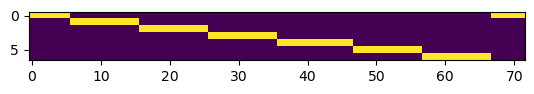

In [20]:
plt.imshow(targets[:, -1,::5])

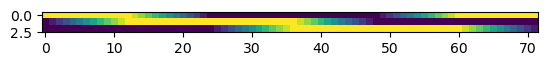

In [21]:
plt.imshow(rgbs[::5, :].T)

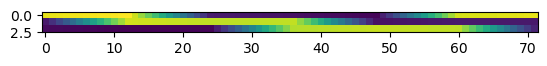

In [22]:
plt.imshow(lmss[::5, :].T)

In [24]:
def smoothness_penalty(states):
    # states has the shape (N, T, batch_size)
    batch_size = states.shape[-1]
    penalty = 0
    # the neighboring colors should not have drastically different responses!
    for i in range(batch_size):
        penalty += torch.mean(torch.pow(states[:, :, i] - states[:, :, (i + 1) % batch_size], 2))
    return penalty

In [25]:
penalty_dict = {"penalty_function" : smoothness_penalty, "lambda_smooth" : config_dict["lambda_smooth"]}
rnn_trained, train_losses, val_losses, net_params = trainer.run_training(train_mask=mask,
                                                                         same_batch=same_batch,
                                                                         penalty_dict=penalty_dict)

iteration 0, train loss: 1.189719, validation loss: 0.866432
iteration 1, train loss: 1.047878, validation loss: 0.870253
iteration 2, train loss: 1.04864, validation loss: 0.869695
iteration 3, train loss: 1.049414, validation loss: 0.868236
iteration 4, train loss: 1.049796, validation loss: 0.866184
iteration 5, train loss: 1.049922, validation loss: 0.863496
iteration 6, train loss: 1.046939, validation loss: 0.860035
iteration 7, train loss: 1.043949, validation loss: 0.855639
iteration 8, train loss: 1.040743, validation loss: 0.850119
iteration 9, train loss: 1.03523, validation loss: 0.843268
iteration 10, train loss: 1.028107, validation loss: 0.834861
iteration 11, train loss: 1.019165, validation loss: 0.82466
iteration 12, train loss: 1.010056, validation loss: 0.812423
iteration 13, train loss: 0.997917, validation loss: 0.797911
iteration 14, train loss: 0.984058, validation loss: 0.780898
iteration 15, train loss: 0.966397, validation loss: 0.761186
iteration 16, train l

iteration 108, train loss: 0.276595, validation loss: 0.08683
iteration 109, train loss: 0.276041, validation loss: 0.086743
iteration 110, train loss: 0.276657, validation loss: 0.086652
iteration 111, train loss: 0.27487, validation loss: 0.086557
iteration 112, train loss: 0.276123, validation loss: 0.086457
iteration 113, train loss: 0.275308, validation loss: 0.086352
iteration 114, train loss: 0.274862, validation loss: 0.086244
iteration 115, train loss: 0.27552, validation loss: 0.08613
iteration 116, train loss: 0.275252, validation loss: 0.08601
iteration 117, train loss: 0.274886, validation loss: 0.085885
iteration 118, train loss: 0.275472, validation loss: 0.085756
iteration 119, train loss: 0.274459, validation loss: 0.085625
iteration 120, train loss: 0.27403, validation loss: 0.08549
iteration 121, train loss: 0.27442, validation loss: 0.08535
iteration 122, train loss: 0.273451, validation loss: 0.085203
iteration 123, train loss: 0.272533, validation loss: 0.085047
i

iteration 217, train loss: 0.245577, validation loss: 0.053765
iteration 218, train loss: 0.246702, validation loss: 0.053354
iteration 219, train loss: 0.245044, validation loss: 0.052976
iteration 220, train loss: 0.245309, validation loss: 0.052681
iteration 221, train loss: 0.246091, validation loss: 0.052308
iteration 222, train loss: 0.24484, validation loss: 0.051939
iteration 223, train loss: 0.24442, validation loss: 0.051621
iteration 224, train loss: 0.243959, validation loss: 0.051345
iteration 225, train loss: 0.243352, validation loss: 0.051105
iteration 226, train loss: 0.243861, validation loss: 0.050846
iteration 227, train loss: 0.244678, validation loss: 0.050643
iteration 228, train loss: 0.244998, validation loss: 0.050533
iteration 229, train loss: 0.243925, validation loss: 0.05041
iteration 230, train loss: 0.244308, validation loss: 0.05042
iteration 231, train loss: 0.24555, validation loss: 0.050349
iteration 232, train loss: 0.244238, validation loss: 0.0501

iteration 330, train loss: 0.230785, validation loss: 0.033219
iteration 331, train loss: 0.228492, validation loss: 0.032531
iteration 332, train loss: 0.230909, validation loss: 0.032329
iteration 333, train loss: 0.22997, validation loss: 0.031877
iteration 334, train loss: 0.230151, validation loss: 0.031395
iteration 335, train loss: 0.22751, validation loss: 0.030867
iteration 336, train loss: 0.228749, validation loss: 0.030657
iteration 337, train loss: 0.228565, validation loss: 0.030417
iteration 338, train loss: 0.227247, validation loss: 0.02995
iteration 339, train loss: 0.229084, validation loss: 0.029763
iteration 340, train loss: 0.226196, validation loss: 0.029099
iteration 341, train loss: 0.225046, validation loss: 0.028724
iteration 342, train loss: 0.228791, validation loss: 0.028624
iteration 343, train loss: 0.230838, validation loss: 0.02816
iteration 344, train loss: 0.228598, validation loss: 0.028443
iteration 345, train loss: 0.228251, validation loss: 0.028

iteration 455, train loss: 0.223657, validation loss: 0.024793
iteration 456, train loss: 0.222345, validation loss: 0.024664
iteration 457, train loss: 0.223132, validation loss: 0.02458
iteration 458, train loss: 0.224232, validation loss: 0.02509
iteration 459, train loss: 0.221702, validation loss: 0.024756
iteration 460, train loss: 0.222612, validation loss: 0.024424
iteration 461, train loss: 0.222222, validation loss: 0.024449
iteration 462, train loss: 0.224309, validation loss: 0.024521
iteration 463, train loss: 0.220696, validation loss: 0.024531
iteration 464, train loss: 0.221381, validation loss: 0.024563
iteration 465, train loss: 0.221866, validation loss: 0.024717
iteration 466, train loss: 0.2226, validation loss: 0.024735
iteration 467, train loss: 0.225512, validation loss: 0.024752
iteration 468, train loss: 0.222018, validation loss: 0.025243
iteration 469, train loss: 0.22494, validation loss: 0.024626
iteration 470, train loss: 0.22387, validation loss: 0.02497

iteration 585, train loss: 0.22189, validation loss: 0.025891
iteration 586, train loss: 0.22356, validation loss: 0.025453
iteration 587, train loss: 0.223888, validation loss: 0.024917
iteration 588, train loss: 0.2202, validation loss: 0.025282
iteration 589, train loss: 0.223733, validation loss: 0.024996
iteration 590, train loss: 0.222474, validation loss: 0.025297
iteration 591, train loss: 0.223683, validation loss: 0.025409
iteration 592, train loss: 0.221678, validation loss: 0.024845
iteration 593, train loss: 0.2241, validation loss: 0.02502
iteration 594, train loss: 0.223739, validation loss: 0.025018
iteration 595, train loss: 0.223302, validation loss: 0.025101
iteration 596, train loss: 0.222535, validation loss: 0.025372
iteration 597, train loss: 0.22214, validation loss: 0.025009
iteration 598, train loss: 0.224459, validation loss: 0.024837
iteration 599, train loss: 0.222691, validation loss: 0.024918
iteration 600, train loss: 0.223723, validation loss: 0.02499
i

iteration 715, train loss: 0.221368, validation loss: 0.025427
iteration 716, train loss: 0.223379, validation loss: 0.025535
iteration 717, train loss: 0.222023, validation loss: 0.026118
iteration 718, train loss: 0.223057, validation loss: 0.025942
iteration 719, train loss: 0.221042, validation loss: 0.025456
iteration 720, train loss: 0.224531, validation loss: 0.025086
iteration 721, train loss: 0.221482, validation loss: 0.025159
iteration 722, train loss: 0.222444, validation loss: 0.025193
iteration 723, train loss: 0.223372, validation loss: 0.025132
iteration 724, train loss: 0.222708, validation loss: 0.025282
iteration 725, train loss: 0.221879, validation loss: 0.024779
iteration 726, train loss: 0.224073, validation loss: 0.024655
iteration 727, train loss: 0.221822, validation loss: 0.024913
iteration 728, train loss: 0.222631, validation loss: 0.02465
iteration 729, train loss: 0.224296, validation loss: 0.02498
iteration 730, train loss: 0.221654, validation loss: 0.0

iteration 846, train loss: 0.221382, validation loss: 0.024911
iteration 847, train loss: 0.222078, validation loss: 0.024784
iteration 848, train loss: 0.220105, validation loss: 0.025581
iteration 849, train loss: 0.222393, validation loss: 0.025006
iteration 850, train loss: 0.22392, validation loss: 0.024657
iteration 851, train loss: 0.223361, validation loss: 0.024793
iteration 852, train loss: 0.223012, validation loss: 0.024837
iteration 853, train loss: 0.221076, validation loss: 0.025104
iteration 854, train loss: 0.221917, validation loss: 0.024888
iteration 855, train loss: 0.221203, validation loss: 0.024772
iteration 856, train loss: 0.22133, validation loss: 0.024759
iteration 857, train loss: 0.221606, validation loss: 0.024668
iteration 858, train loss: 0.221302, validation loss: 0.024833
iteration 859, train loss: 0.222533, validation loss: 0.025248
iteration 860, train loss: 0.222514, validation loss: 0.024925
iteration 861, train loss: 0.220438, validation loss: 0.0

iteration 977, train loss: 0.223622, validation loss: 0.024781
iteration 978, train loss: 0.224003, validation loss: 0.024824
iteration 979, train loss: 0.222026, validation loss: 0.024945
iteration 980, train loss: 0.22328, validation loss: 0.025137
iteration 981, train loss: 0.222515, validation loss: 0.02507
iteration 982, train loss: 0.221973, validation loss: 0.024848
iteration 983, train loss: 0.220218, validation loss: 0.024719
iteration 984, train loss: 0.222841, validation loss: 0.024751
iteration 985, train loss: 0.222538, validation loss: 0.025193
iteration 986, train loss: 0.22075, validation loss: 0.02524
iteration 987, train loss: 0.221233, validation loss: 0.024736
iteration 988, train loss: 0.221222, validation loss: 0.024604
iteration 989, train loss: 0.222122, validation loss: 0.024312
iteration 990, train loss: 0.222405, validation loss: 0.02452
iteration 991, train loss: 0.222386, validation loss: 0.024803
iteration 992, train loss: 0.222004, validation loss: 0.0245

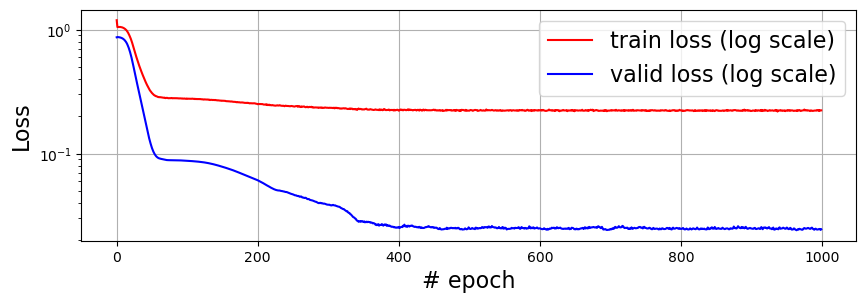

In [26]:
fig_trainloss = plt.figure(figsize=(10, 3))
plt.plot(train_losses, color='r', label='train loss (log scale)')
plt.plot(val_losses, color='b', label='valid loss (log scale)')
plt.yscale("log")
plt.grid(True)
plt.xlabel("# epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(fontsize=16)
if disp:
    plt.show()
if not (datasaver is None): datasaver.save_figure(fig_trainloss, "train&valid_loss")

In [27]:
# net_params = json.load(open(os.path.join(get_project_root(), "data",
#                                          "trained_RNNs",
#                                          "ColorDiscrimination",
#                                          "0.0140972_ColorDiscrimination;relu;N=194;lmbdo=0.3;lmbds=0.03;lmbdr=0.5;lr=0.005;maxiter=10000",
#                                          "0.0140972_params_ColorDiscrimination.json")))

In [28]:
# validate
RNN_valid = RNN_numpy(N=net_params["N"],
                      dt=net_params["dt"],
                      tau=net_params["tau"],
                      activation=numpify(activation),
                      W_inp=np.array(net_params["W_inp"]),
                      W_rec=np.array(net_params["W_rec"]),
                      W_out=np.array(net_params["W_out"]),
                      bias_rec=net_params["bias_rec"],
                      y_init=np.array(net_params["y_init"]))

In [29]:
input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()

In [30]:
analyzer = PerformanceAnalyzer(RNN_valid)
score_function = lambda x, y: np.mean((x - y) ** 2)
score = analyzer.get_validation_score(score_function, input_batch_valid, target_batch_valid,
                                      mask, sigma_rec=0, sigma_inp=0)

In [31]:
print(f"MSE validation: {np.round(score, 5)}")

MSE validation: 0.01853


In [32]:
inds = np.random.choice(np.arange(input_batch_valid.shape[-1]), 5)
inputs = input_batch_valid[..., inds]
targets = target_batch_valid[..., inds]

In [33]:
inputs.shape

(3, 120, 5)

In [34]:
RNN_valid.clear_history()
RNN_valid.run(input_timeseries=input_batch_valid)
output = RNN_valid.get_output()

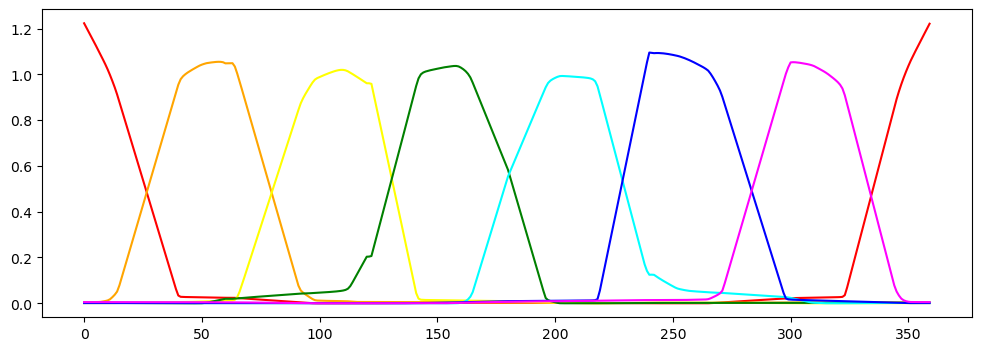

In [38]:
color_labels = ["red", "orange", 
          "yellow", "green", "cyan",
          "blue", "magenta"]
colors = deepcopy(color_labels)

# color_labels = ["red", "vermillion", "orange", "amber",
#           "yellow", "chartreuse", "green", "cyan",
#           "blue", "indigo", "violet", "magenta"]
# colors = ["red", "#E34234", "orange", "#FFBF00",
#           "yellow", "#7fff00", "green", "cyan",
#           "blue", "#6D5ACF", "#7F00FF", "magenta"]
fig = plt.figure(figsize = (12, 4))
for i in range(len(colors)):
    plt.plot(np.hstack([output[i, -1, :].T]), color=colors[i])

In [ ]:
from tqdm.auto import tqdm
dsa = DynamicSystemAnalyzer(RNN_valid)
n = 90
for i in tqdm(range(n)):
    hsv = (i * (1./n), 1, 1)
    rgb = task.hsv_to_rgb(*hsv)
    input_stream, target_stream, condition = task.generate_input_target_stream(rgb)
    dsa.get_fixed_points(Input=input_stream[:, 0], patience = 10, stop_length=1, mode='exact')

  0%|          | 0/90 [00:00<?, ?it/s]

In [51]:
np.set_printoptions(suppress=True)
# dsa.fp_data

{'[1.0, 0.029474722037037573, 0.0]': {'stable_fps': array([[-0.        , -0.        , -0.        ,  0.15492627, -0.        ,
          -0.        ,  0.        ,  0.34719497, -0.        ,  0.        ,
           0.13046207,  0.        , -0.        , -0.        ,  0.        ,
           0.39324197, -0.        , -0.        , -0.        , -0.        ,
          -0.        , -0.        , -0.        ,  0.27208561,  0.        ,
          -0.        ,  0.01670981,  0.14968728, -0.        ,  0.31580123,
          -0.        ,  0.        , -0.        , -0.        ,  0.29196107,
          -0.        ,  0.        ,  0.        ,  0.        , -0.        ,
          -0.        ,  0.42674398, -0.        , -0.        ,  0.        ,
          -0.        , -0.        , -0.        , -0.        ,  0.06228046,
          -0.        ,  0.33746484, -0.        ,  0.41430759,  0.        ,
          -0.        , -0.        , -0.        ,  0.        ,  0.15889783,
          -0.        ,  0.36501872, -0.        , -

In [52]:
points = []
for key in dsa.fp_data.keys():
    try:
        points.append(dsa.fp_data[key]['stable_fps'])
    except:
        pass

In [56]:
points_colors = []
n_outputs = RNN_valid.W_out.shape[0]
color_list = ["red", "orange", 
           "yellow",  "green", "cyan",
           "blue", "magenta"]
for i in tqdm(range(n)):
    hue = i * (1./n)
    hsv = (hue, 1, 1)
    rgb = task.hsv_to_rgb(*hsv)
    color_ind = int(((hue + 1.0 / (2 * n_outputs)) % 1) // (1.0 / n_outputs))
    points_colors.append(color_list[color_ind])
points = np.vstack(points)

  0%|          | 0/180 [00:00<?, ?it/s]

In [57]:
from sklearn.decomposition import PCA
P = PCA(n_components=3)
P.fit(points)
points_pr = points @ P.components_.T

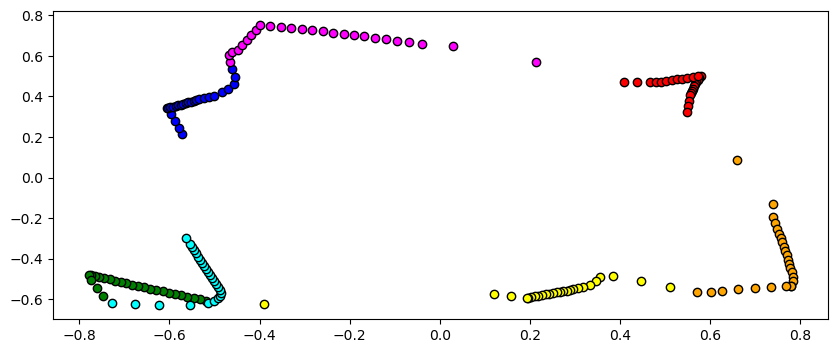

In [58]:
fig_fp, ax = plt.subplots(1, 1, figsize = (10, 4))
for i in range(points_pr.shape[0]):
    ax.scatter(points_pr[i, 0], points_pr[i, 1], color = points_colors[i], edgecolor = 'k')

# clustering analysis, multiple networks

In [20]:
from rnn_coach.src.utils import get_colormaps
np.set_printoptions(suppress = True)
colors, cmp = get_colormaps()

def permute_input_matrix(mat, order):
    new_mat = np.empty_like(mat)
    for i, r in enumerate(order):
        new_mat[i, :] = mat[r, :]
    return new_mat

def permute_output_matrix(mat, order):
    new_mat = np.empty_like(mat)
    for i, c in enumerate(order):
        new_mat[:, i] = mat[:, c]
    return new_mat

def permute_recurrent_matrix(mat, order):
    new_mat = permute_input_matrix(mat, order)
    new_mat = permute_output_matrix(new_mat, order)
    return new_mat

def bitstr(row: np.ndarray, th) -> str:
    return ''.join((row > th).astype(int).astype(str))

def get_ordering(W_inp, th=0.0):
    bitstrings = [(bitstr(W_inp[idx, :], th), idx) for idx in range(W_inp.shape[0])]
    bitstrings = sorted(bitstrings, key=lambda x: x[0], reverse=True)
    idxs = [idx for _, idx in bitstrings]
    return idxs

def plot_matrix(mat, vmin=None, vmax=None, show_numbers = False, figsize = (7,7)):
    if vmin is None:
        vmin = np.min(mat)
    if vmax is None:
        vmax = np.max(mat)    
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    img = ax.imshow(mat, cmap=cmp, vmin = vmin, vmax = vmax)
    if show_numbers:
        for (i, j), z in np.ndenumerate(mat):
            if np.abs(z) > 0.01:
                ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k', fontsize=7)
    ax.set_xticks(np.arange(mat.shape[1])[::2])
    ax.set_yticks(np.arange(mat.shape[0])[::2])
    plt.show()
    
def take_elements(mat, inds_rows, inds_cols):
    mat = mat[inds_rows, :]
    return mat[:, inds_cols]

def plot_neurons_stats(neural_traces, conditions, task_params):
    # traces_nrn - matrix K x T, where K is the number of conditions, T - timesteps
    cue_on = task_params["cue_on"]
    cue_off = task_params["cue_off"]
    stim_on = task_params["stim_on"]
    stim_off = task_params["stim_off"]
    dec_on = task_params["dec_on"]
    dec_off = task_params["dec_off"]
    cohrences_list = task_params["coherences"]
    
    contexts = np.array([1 if d["context"]=='motion' else 0 for d in conditions])
    motion_coherences = np.array([d["motion_coh"] for d in conditions])
    color_coherences = np.array([d["color_coh"] for d in conditions])
    inds_motion_ctxt = np.where(contexts==1)[0]
    inds_color_ctxt = np.where(contexts==0)[0]

    data_dict = {}
    for ctx in ["motion", "color"]:
        val = 1 if ctx == 'motion' else 0
        inds_context = np.where(contexts==val)[0]
        for part in ["start", "end"]:
            if part == 'start':
                mfr = np.mean(neural_traces[inds_context, :stim_on], axis = 1)
            elif part == 'end':
                mfr = np.mean(neural_traces[inds_context, stim_on:], axis = 1)

            M = np.zeros((len(cohrences_list), len(cohrences_list)))
            for i in range(len(mfr)):
                coh_motion = np.take(motion_coherences, inds_context)[i]
                coh_color = np.take(color_coherences, inds_context)[i]
                i1 = np.where(cohrences_list == coh_motion)[0][0]
                i2 = np.where(cohrences_list == coh_color)[0][0]
                M[i1, i2] = mfr[i]
            data_dict[(ctx, part)] = deepcopy(M)
            
    figure, ax = plt.subplots(2, 2, figsize = (7, 7))
    plt.suptitle("Neural responses", fontsize = 16)
    imgs = []
    for i, ctx in enumerate(["motion", "color"]):
        for j, part in enumerate(["start", "end"]):
            imgs.append(ax[j, i].imshow(data_dict[(ctx, part)], cmap = 'coolwarm', interpolation='bicubic'))
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])
    for i in range(2):
        ax[1, i].set_xlabel("Color", fontsize = 14)
        ax[i, 0].set_ylabel("Motion", fontsize = 14)
        ax[1, i].set_xticks(np.arange(len(cohrences_list)), cohrences_list, rotation = 50, fontsize = 7)
        ax[i, 0].set_yticks(np.arange(len(cohrences_list)), cohrences_list, rotation = 50, fontsize = 7)
    cnt = 0
    for i, ctx in enumerate(["motion", "color"]):
        for j, part in enumerate(["start", "end"]):        
            figure.colorbar(imgs[cnt], ax=ax[j, i], cax=ax[j, i].inset_axes([1.05, 0, 0.05, 1]))
            cnt+=1

    plt.subplots_adjust(hspace = 0.0, wspace = 0.35)
    plt.show()


In [22]:
lambda_smooth = 0.1
lambda_orth = 0.3
N = 80
path = os.path.join(get_project_root(), "data","trained_RNNs", "ColorDiscrimination")
subdirs = os.listdir(path)
exc_traces_combined = []
inh_traces_combined = []
exc_nrn_inputs = []
inh_nrn_inputs = []
exc_nrn_outputs = []
inh_nrn_outputs = []
W_recs = []
W_inps = []
W_outs = []
cnt = 0
# subdirs = ['0.0139652_ColorDiscrimination;relu;N=198;lmbdo=0.3;lmbds=0.03;lmbdr=0.5;lr=0.005;maxiter=10000',
#           '0.0143875_ColorDiscrimination;relu;N=196;lmbdo=0.3;lmbds=0.03;lmbdr=0.5;lr=0.005;maxiter=10000',
#           '0.0147146_ColorDiscrimination;relu;N=196;lmbdo=0.3;lmbds=0.03;lmbdr=0.5;lr=0.005;maxiter=10000',
#            '0.0140477_ColorDiscrimination;relu;N=197;lmbdo=0.3;lmbds=0.03;lmbdr=0.5;lr=0.005;maxiter=10000',
#            '0.0140972_ColorDiscrimination;relu;N=194;lmbdo=0.3;lmbds=0.03;lmbdr=0.5;lr=0.005;maxiter=10000',
#           '0.0137114_ColorDiscrimination;relu;N=193;lmbdo=0.3;lmbds=0.03;lmbdr=0.5;lr=0.005;maxiter=10000'][0:3]
for subdir in subdirs:
    if subdir == '.DS_Store':
        pass
    else:
        path_to_net = os.path.join(path, subdir)
        score = float(subdir.split("_")[0])
        config = json.load(open(os.path.join(path_to_net, f"{score}_config.json"), "rb+"))
        #and config["lambda_orth"] == lambda_orth and (config["N"] >= N) and 
        net_params = json.load(open(os.path.join(path_to_net, f"{score}_params_ColorDiscrimination.json"), "rb+"))
        if np.array(net_params["W_out"]).shape[0]==7 and config["lambda_smooth"] == lambda_smooth:
            print(subdir)
            RNN = RNN_numpy(N=net_params["N"],
                                  dt=net_params["dt"],
                                  tau=net_params["tau"],
                                  activation=numpify(activation),
                                  W_inp=np.array(net_params["W_inp"]),
                                  W_rec=np.array(net_params["W_rec"]),
                                  W_out=np.array(net_params["W_out"]),
                                  bias_rec=net_params["bias_rec"],
                                  y_init=np.array(net_params["y_init"]))
            RNN.clear_history()
            RNN.run(input_timeseries=input_batch_valid)
            traces = RNN.get_history()
            inh_ind = np.where(np.mean(RNN.W_rec, axis = 0) < 0)[0]
            exc_ind = np.where(np.mean(RNN.W_rec, axis = 0) >= 0)[0]
            traces_exc = traces[exc_ind, :, :]
            traces_inh = traces[inh_ind, :, :]
            
            exc_traces_combined.append(traces_exc)
            inh_traces_combined.append(traces_inh)
            exc_nrn_inputs.append(RNN.W_inp[exc_ind, :])
            inh_nrn_inputs.append(RNN.W_inp[inh_ind, :])
            exc_nrn_outputs.append(RNN.W_out[:, exc_ind])
            inh_nrn_outputs.append(RNN.W_out[:, inh_ind])
            W_recs.append(deepcopy(RNN.W_rec))
            W_inps.append(deepcopy(RNN.W_inp))
            W_outs.append(deepcopy(RNN.W_out))
            cnt+=1
            
exc_traces_combined = np.vstack(exc_traces_combined)
inh_traces_combined = np.vstack(inh_traces_combined)
exc_inputs = np.vstack(exc_nrn_inputs)
inh_inputs = np.vstack(inh_nrn_inputs)
exc_outputs = np.hstack(exc_nrn_outputs).T
inh_outputs = np.hstack(inh_nrn_outputs).T

0.0186251_ColorDiscrimination;relu;N=100;lmbdo=0.0;lmbds=0.1;lmbdr=0.5;lr=0.005;maxiter=3000
0.0178358_ColorDiscrimination;relu;N=99;lmbdo=0.3;lmbds=0.1;lmbdr=0.5;lr=0.005;maxiter=3000
0.0183071_ColorDiscrimination;relu;N=98;lmbdo=0.0;lmbds=0.1;lmbdr=0.5;lr=0.005;maxiter=3000
0.0184111_ColorDiscrimination;relu;N=98;lmbdo=0.0;lmbds=0.1;lmbdr=0.5;lr=0.005;maxiter=3000
0.0181513_ColorDiscrimination;relu;N=96;lmbdo=0.3;lmbds=0.1;lmbdr=0.5;lr=0.005;maxiter=3000
0.0185353_ColorDiscrimination;relu;N=99;lmbdo=0.0;lmbds=0.1;lmbdr=0.5;lr=0.005;maxiter=3000
0.018151_ColorDiscrimination;relu;N=100;lmbdo=0.3;lmbds=0.1;lmbdr=0.5;lr=0.005;maxiter=3000
0.0187127_ColorDiscrimination;relu;N=100;lmbdo=0.0;lmbds=0.1;lmbdr=0.5;lr=0.005;maxiter=3000
0.0180073_ColorDiscrimination;relu;N=100;lmbdo=0.0;lmbds=0.1;lmbdr=0.5;lr=0.005;maxiter=3000
0.0185444_ColorDiscrimination;relu;N=100;lmbdo=0.0;lmbds=0.1;lmbdr=0.5;lr=0.005;maxiter=3000
0.0172957_ColorDiscrimination;relu;N=95;lmbdo=0.0;lmbds=0.1;lmbdr=0.5;lr=0.0

In [23]:
exc_traces_combined.shape

(3146, 120, 360)

In [24]:
# WINP = np.vstack(W_inps)
# WOUT = np.hstack(W_outs)
# WREC = scipy.linalg.block_diag(*W_recs)

In [25]:
for subdir in subdirs:
    if subdir == '.DS_Store':
        pass
    else:
        path_to_net = os.path.join(path, subdir)
        score = float(subdir.split("_")[0])
        config = json.load(open(os.path.join(path_to_net, f"{score}_config.json"), "rb+"))
        if config["lambda_smooth"] == lambda_smooth and config["lambda_orth"] == lambda_orth:
            net_params = json.load(open(os.path.join(path_to_net, f"{score}_params_ColorDiscrimination.json"), "rb+"))
            RNN = RNN_numpy(N=net_params["N"],
                                  dt=net_params["dt"],
                                  tau=net_params["tau"],
                                  activation=numpify(activation),
                                  W_inp=np.array(net_params["W_inp"]),
                                  W_rec=np.array(net_params["W_rec"]),
                                  W_out=np.array(net_params["W_out"]),
                                  bias_rec=net_params["bias_rec"],
                                  y_init=np.array(net_params["y_init"]))
        

In [26]:
F_inh = np.mean(inh_traces_combined[:, mask, :], axis = 1)
F_exc = np.mean(exc_traces_combined[:, mask, :], axis = 1)
F_z_inh = zscore(F_inh)
F_z_exc = zscore(F_exc)

In [27]:
P = PCA(n_components=3)
P.fit(F_z_inh)
F_z_inh_pr = F_z_inh @ P.components_.T

P = PCA(n_components=3)
P.fit(F_z_exc)
F_z_exc_pr = F_z_exc @ P.components_.T

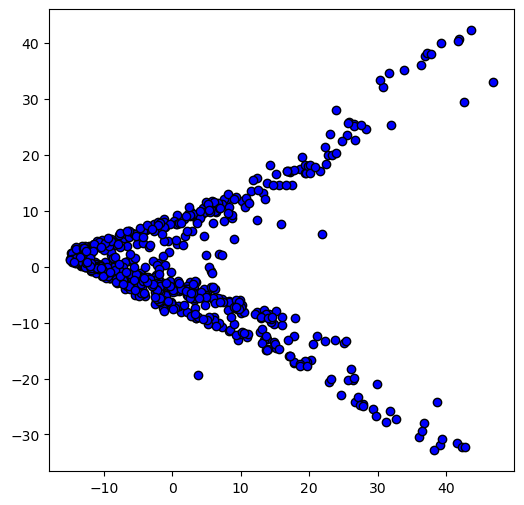

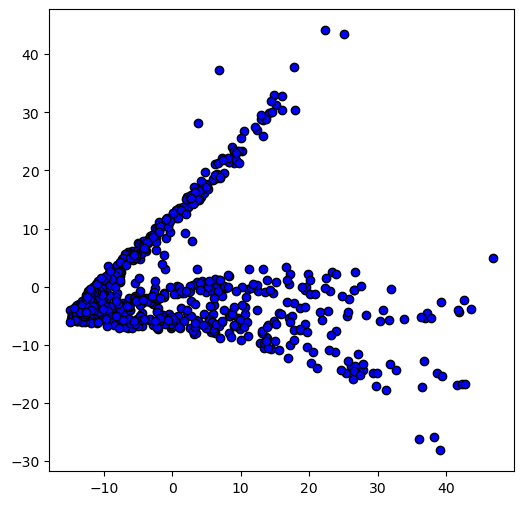

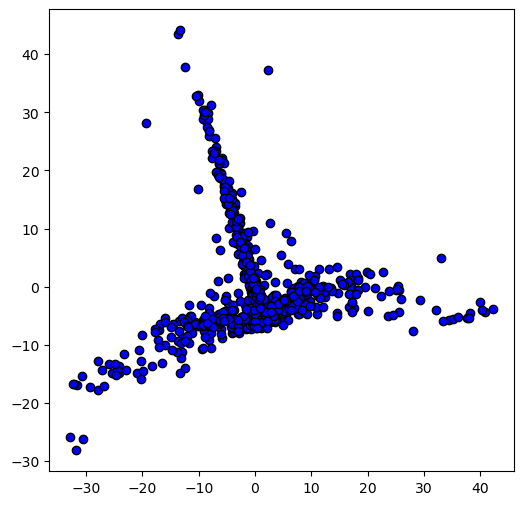

In [28]:
fig, ax = plt.subplots(1, 1, figsize = (6,6))
ax.scatter(F_z_inh_pr[:, 0], F_z_inh_pr[:, 1], color = 'b', edgecolor = 'k')
plt.show()

fig, ax = plt.subplots(1, 1, figsize = (6,6))
ax.scatter(F_z_inh_pr[:, 0], F_z_inh_pr[:, 2], color = 'b', edgecolor = 'k')
plt.show()

fig, ax = plt.subplots(1, 1, figsize = (6,6))
ax.scatter(F_z_inh_pr[:, 1], F_z_inh_pr[:, 2], color = 'b', edgecolor = 'k')
plt.show()

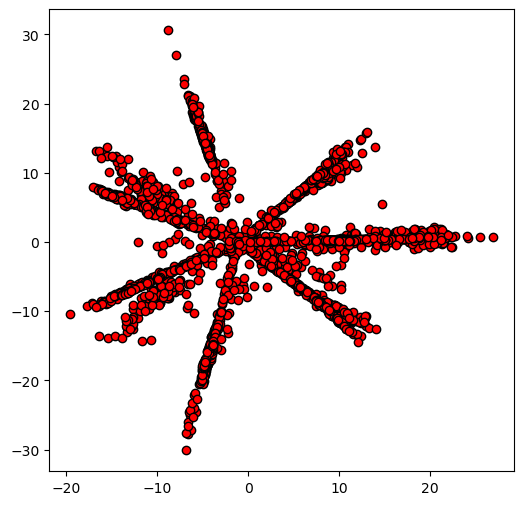

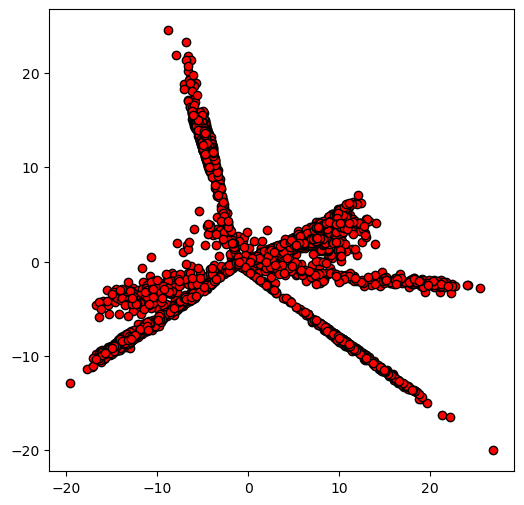

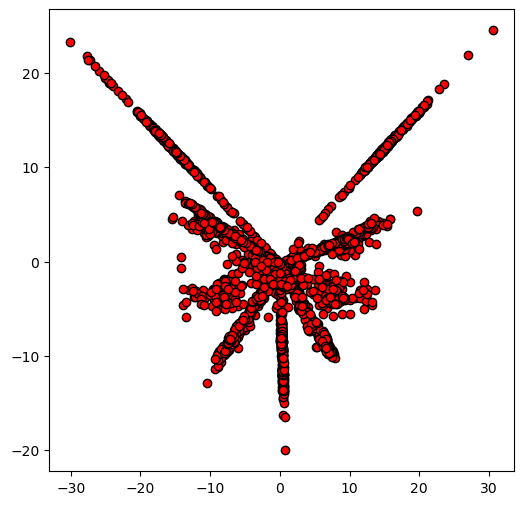

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (6,6))
ax.scatter(F_z_exc_pr[:, 0], F_z_exc_pr[:, 1], color = 'r', edgecolor = 'k')
plt.show()

fig, ax = plt.subplots(1, 1, figsize = (6,6))
ax.scatter(F_z_exc_pr[:, 0], F_z_exc_pr[:, 2], color = 'r', edgecolor = 'k')
plt.show()

fig, ax = plt.subplots(1, 1, figsize = (6,6))
ax.scatter(F_z_exc_pr[:, 1], F_z_exc_pr[:, 2], color = 'r', edgecolor = 'k')
plt.show()

In [31]:
L = 15
num_rep = 11
sill_score_array = np.zeros((L-3, num_rep))
for i in tqdm(range(3, L)):
    for j in range(num_rep):
        clusterer = KMeans(n_clusters = i)
        labels = clusterer.fit_predict(F_z_exc)
        sill_score_array[i-3, j] = deepcopy(silhouette_score(F_z_exc, labels))
sill_scores = np.mean(sill_score_array, axis=1)

  0%|          | 0/12 [00:00<?, ?it/s]

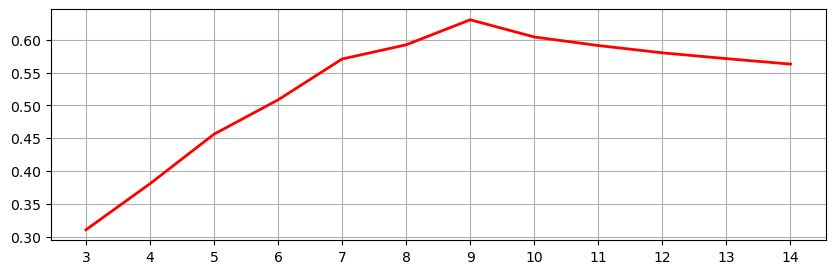

In [32]:
fig, ax = plt.subplots(figsize = (10, 3))
ax.plot(sill_scores, linewidth=2, color='r')
ax.set_xticks(np.arange(L-3))
ax.set_xticklabels(labels = np.arange(3, L))
plt.grid(True)
plt.show()

In [45]:
clusterer_exc = KMeans(n_clusters=11)
labels_exc = clusterer_exc.fit_predict(F_z_exc)

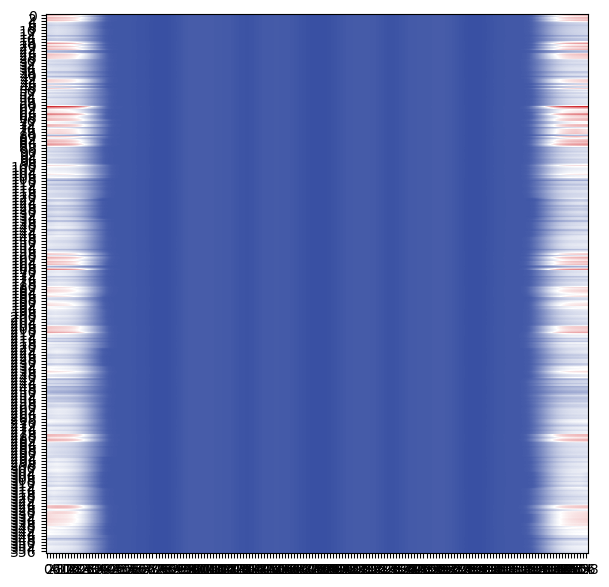

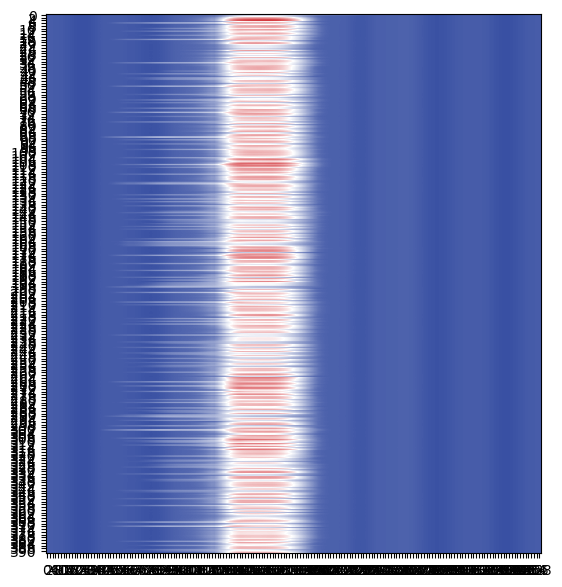

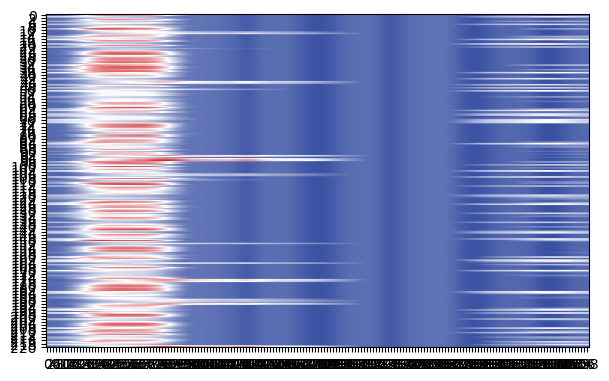

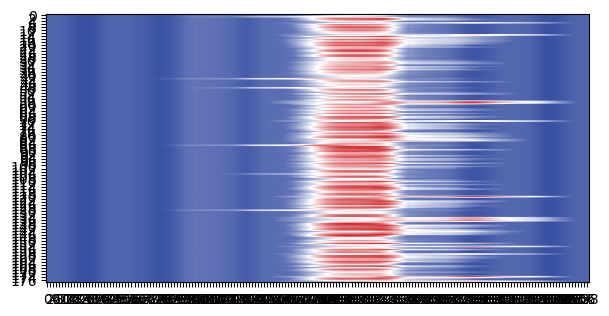

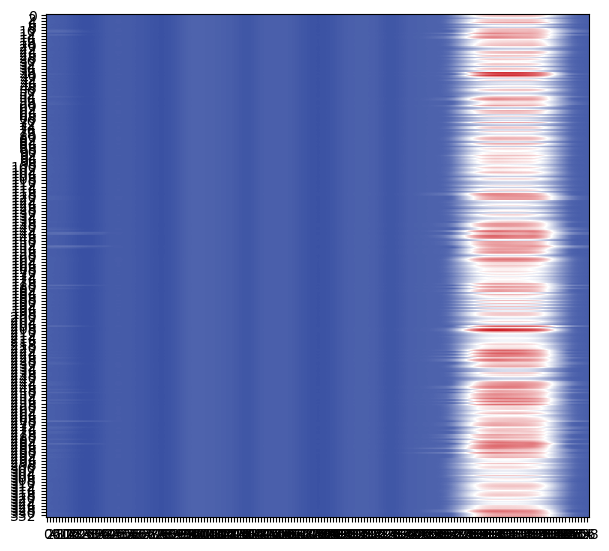

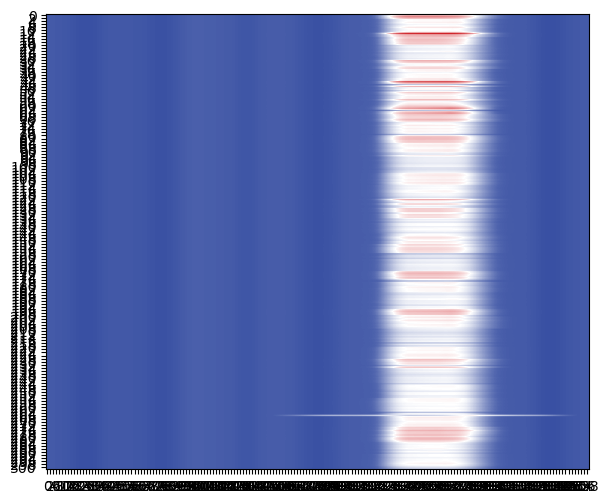

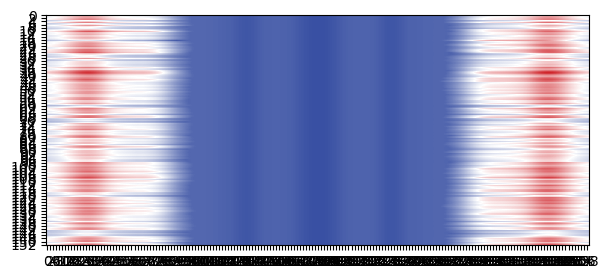

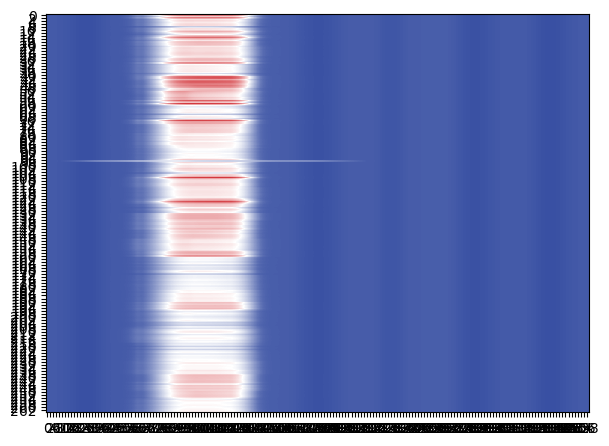

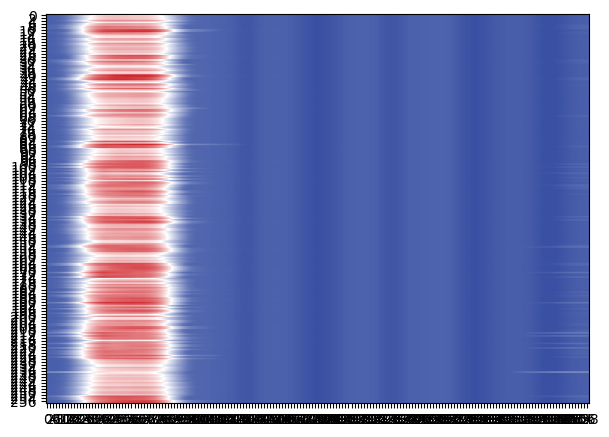

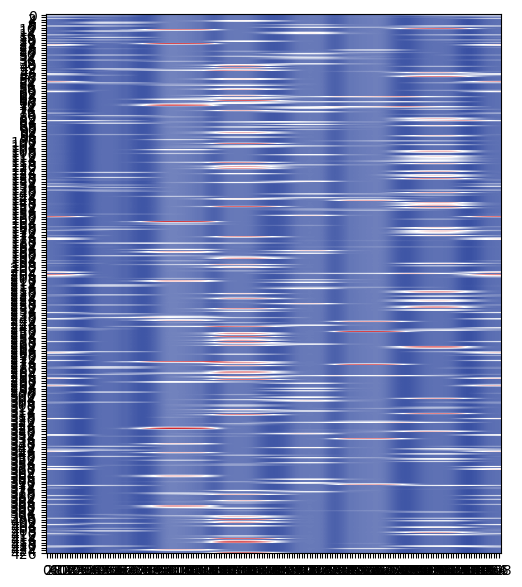

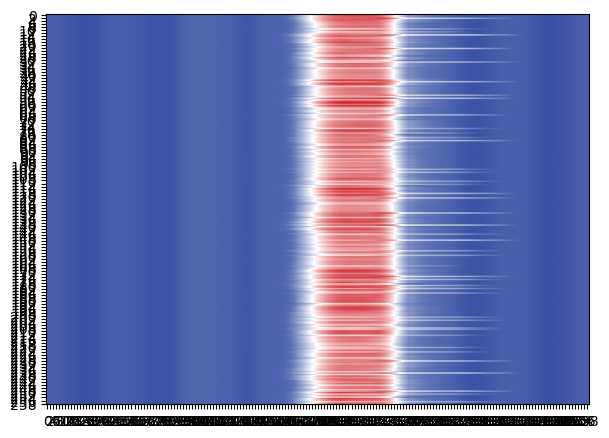

In [46]:
for i in np.unique(labels_exc):
    plot_matrix(F_z_exc[np.where(labels_exc == i)[0],:])

In [36]:
L = 12
num_rep = 11
sill_score_array = np.zeros((L-3, num_rep))
for i in tqdm(range(3, L)):
    for j in range(num_rep):
        clusterer = KMeans(n_clusters = i)
        labels = clusterer.fit_predict(F_z_inh)
        sill_score_array[i-3, j] = deepcopy(silhouette_score(F_z_inh, labels))
sill_scores = np.mean(sill_score_array, axis=1)

  0%|          | 0/9 [00:00<?, ?it/s]

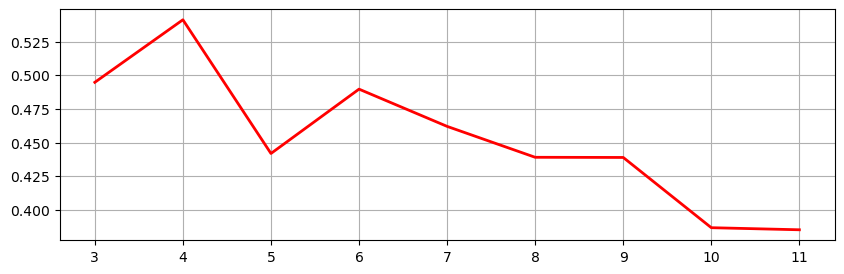

In [37]:
fig, ax = plt.subplots(figsize = (10, 3))
ax.plot(sill_scores, linewidth=2, color='r')
ax.set_xticks(np.arange(L-3))
ax.set_xticklabels(labels = np.arange(3, L))
plt.grid(True)
plt.show()

In [38]:
clusterer_inh = KMeans(n_clusters=4)
labels_inh = clusterer_inh.fit_predict(F_z_inh)

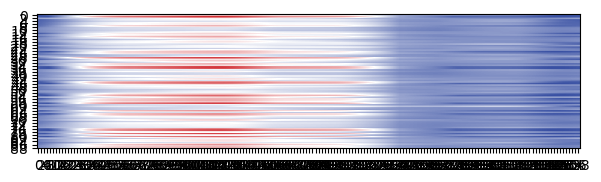

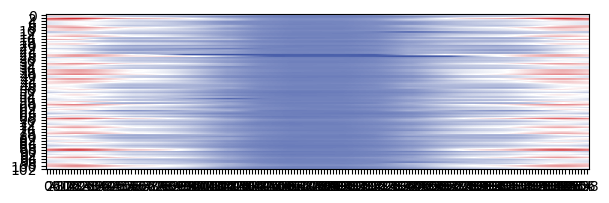

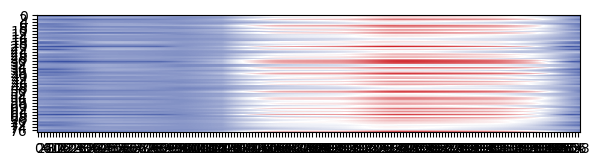

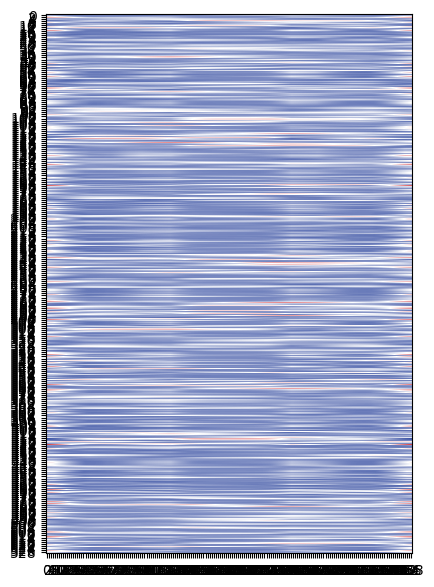

In [39]:
for i in np.unique(labels_inh):
    plot_matrix(F_z_inh[np.where(labels_inh == i)[0],:])

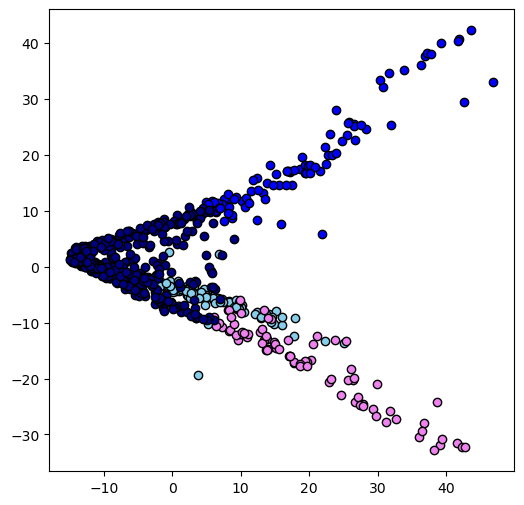

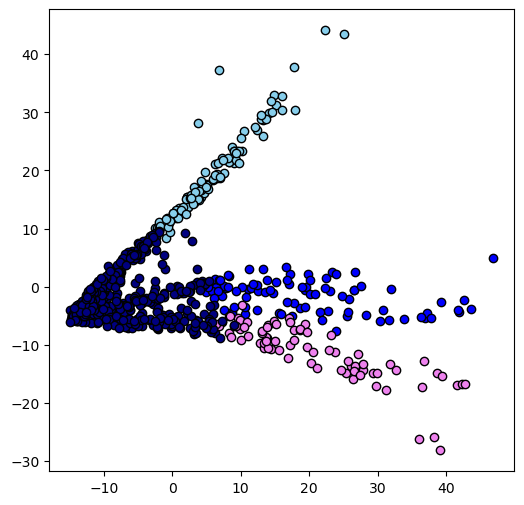

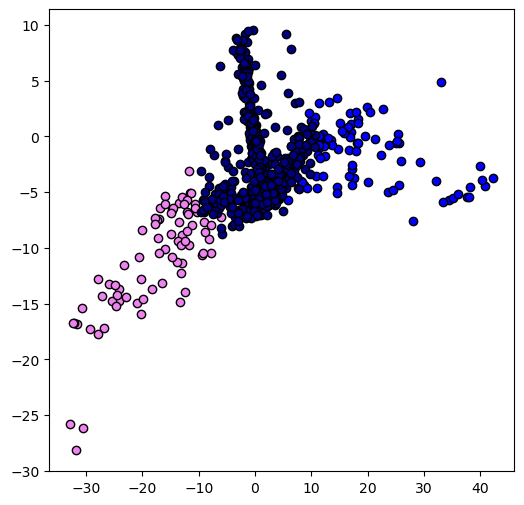

In [40]:
colors = ["blue", "skyblue", "violet", "navy", 'purple', 'brown', 'olive', 'green']

fig, ax = plt.subplots(1, 1, figsize = (6,6))
for i in (np.unique(labels_inh)):
    np.round(np.median(inh_inputs[np.where(labels_inh == i)[0]], axis = 0))
    ax.scatter(F_z_inh_pr[np.where(labels_inh == i)[0], 0], F_z_inh_pr[np.where(labels_inh == i)[0], 1], color = colors[i], edgecolor = 'k')
plt.show()

fig, ax = plt.subplots(1, 1, figsize = (6,6))
for i in (np.unique(labels_inh)):
    ax.scatter(F_z_inh_pr[np.where(labels_inh == i)[0], 0], F_z_inh_pr[np.where(labels_inh == i)[0], 2], color = colors[i], edgecolor = 'k')
plt.show()

fig, ax = plt.subplots(1, 1, figsize = (6,6))
for i in (np.unique(labels_inh)):
    if i != 1:
        ax.scatter(F_z_inh_pr[np.where(labels_inh == i)[0], 1], F_z_inh_pr[np.where(labels_inh == i)[0], 2], color = colors[i], edgecolor = 'k')
plt.show()

In [47]:
classes_inh = []
for i in (np.unique(labels_inh)):
    print(i, ", inputs")
    res = np.round(np.median(inh_inputs[np.where(labels_inh == i)[0]], axis = 0),3)
    print(res)
    if np.max(res) > 0.1:
        classes_inh.append(f"inh_{i}")

0 , inputs
[0.    0.516 0.009]
1 , inputs
[0.318 0.    0.   ]
2 , inputs
[0.    0.004 0.538]
3 , inputs
[0.012 0.    0.   ]


***Thus there are 3 definitive clusters of inhibitory neurons.
Each one receives input from one corresponding cone!***

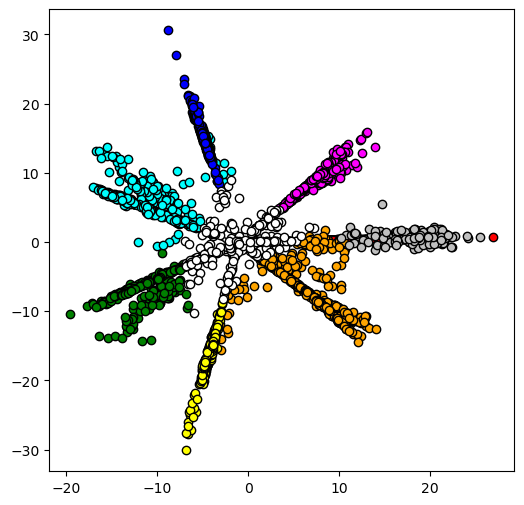

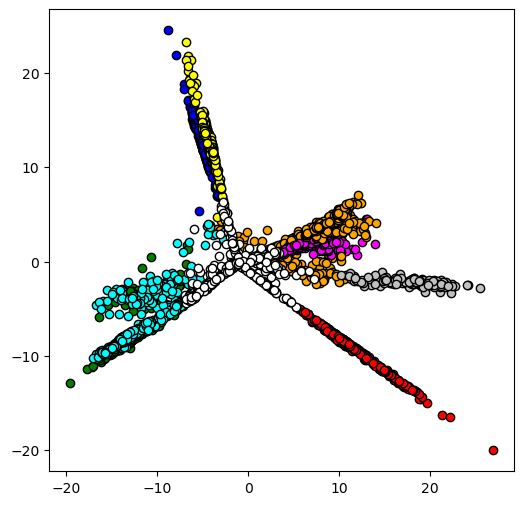

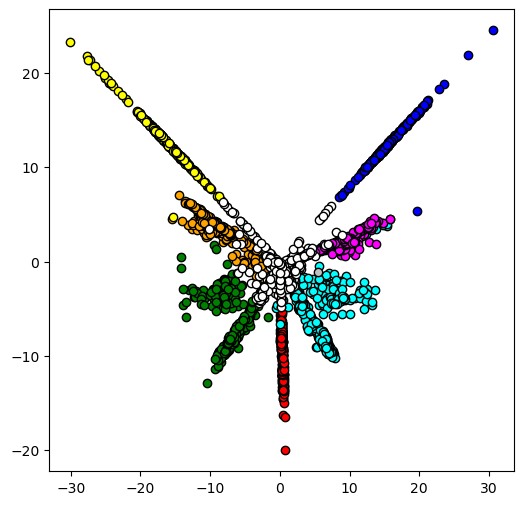

In [48]:
# color_labels = ["red", "vermillion", "orange", "amber",
#           "yellow", "chartreuse", "green", "cyan",
#           "blue", "indigo", "violet", "magenta"]
# colors = ["red", "#E34234", "orange", "#FFBF00",
#           "yellow", "#7fff00", "green", "cyan",
#           "blue", "#6D5ACF", "#7F00FF", "magenta"]

color_labels = ["red", "orange", 
          "yellow", "green", "cyan",
          "blue", "magenta"]
colors = ["red", "orange", 
          "yellow", "green", "cyan",
          "blue", "magenta"]

colors_backup = ["silver", "white", "lightsteelblue"]

label_color_dict = {}
fig, ax = plt.subplots(1, 1, figsize = (6,6))
cnt = 0
for i in (np.unique(labels_exc)):
    outs = np.round(np.median(exc_outputs[np.where(labels_exc == i)[0]], axis = 0),3)
    if np.max(outs) > 0.1:
        color_ind = np.argmax(outs)
        color_label = color_labels[color_ind]
        color = colors[color_ind]
    else:
        color_label = colors_backup[cnt]
        color = colors_backup[cnt]
        cnt+=1
    key_colors = [s.split("_")[0] for s in label_color_dict.keys()]
    if color in key_colors:
        j = 0
        for key in label_color_dict.keys():
            if color in key:
                j+=1
        label_color_dict[color_label + str(f"_{j}")]  = i  
    else:
        label_color_dict[color_label + str("_0")]  = i  
    ax.scatter(F_z_exc_pr[np.where(labels_exc == i)[0], 0], F_z_exc_pr[np.where(labels_exc == i)[0], 1], color = color, edgecolor = 'k')
plt.show()

fig, ax = plt.subplots(1, 1, figsize = (6,6))
cnt = 0
for i in (np.unique(labels_exc)):
    outs = np.round(np.median(exc_outputs[np.where(labels_exc == i)[0]], axis = 0),3)
    if np.max(outs) > 0.1:
        color_ind = np.argmax(outs)
        color = colors[color_ind]
    else:
        color = colors_backup[cnt]
        cnt+=1
    ax.scatter(F_z_exc_pr[np.where(labels_exc == i)[0], 0], F_z_exc_pr[np.where(labels_exc == i)[0], 2], color = color, edgecolor = 'k')
plt.show()

fig, ax = plt.subplots(1, 1, figsize = (6,6))
cnt = 0
for i in (np.unique(labels_exc)):
    outs = np.round(np.median(exc_outputs[np.where(labels_exc == i)[0]], axis = 0),3)
    if np.max(outs) > 0.1:
        color_ind = np.argmax(outs)
        color = colors[color_ind]
    else:
        color = colors_backup[cnt]
        cnt+=1
    ax.scatter(F_z_exc_pr[np.where(labels_exc == i)[0], 1], F_z_exc_pr[np.where(labels_exc == i)[0], 2], color = color, edgecolor = 'k')
plt.show()

In [49]:
label_color_dict

{'red_0': 0,
 'green_0': 1,
 'orange_0': 2,
 'cyan_0': 3,
 'magenta_0': 4,
 'blue_0': 5,
 'silver_0': 6,
 'yellow_0': 7,
 'orange_1': 8,
 'white_0': 9,
 'cyan_1': 10}

red_0


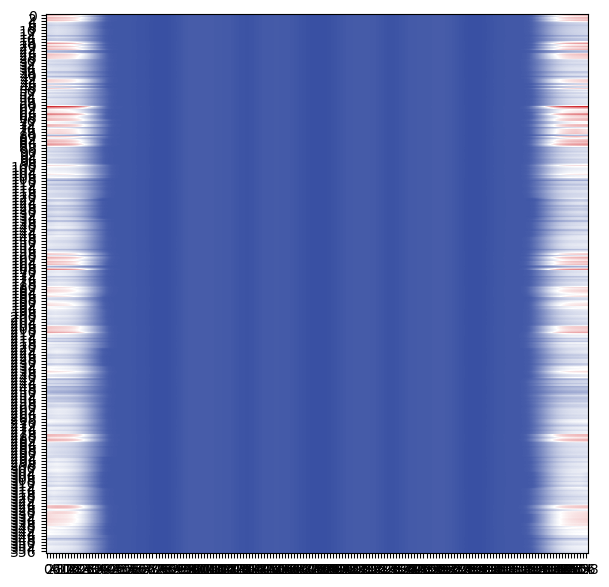

orange_0


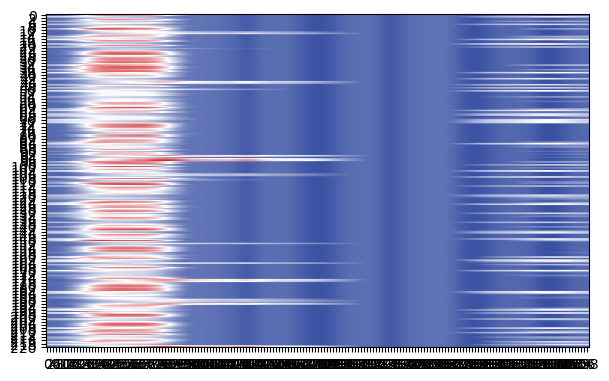

orange_1


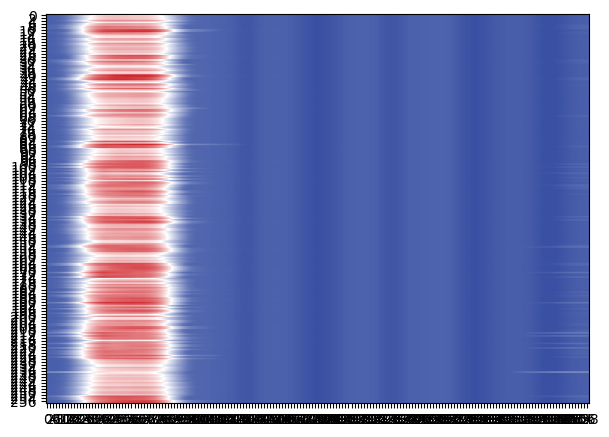

yellow_0


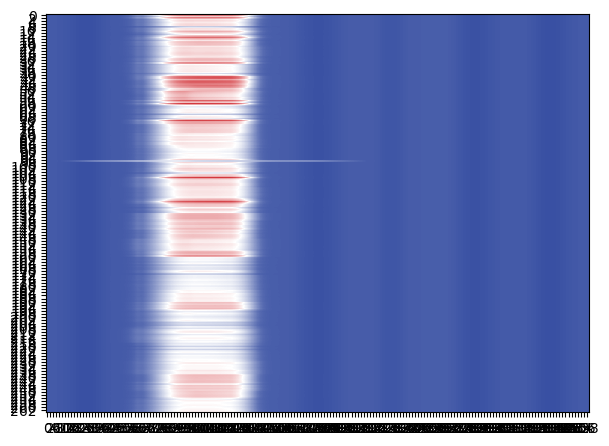

green_0


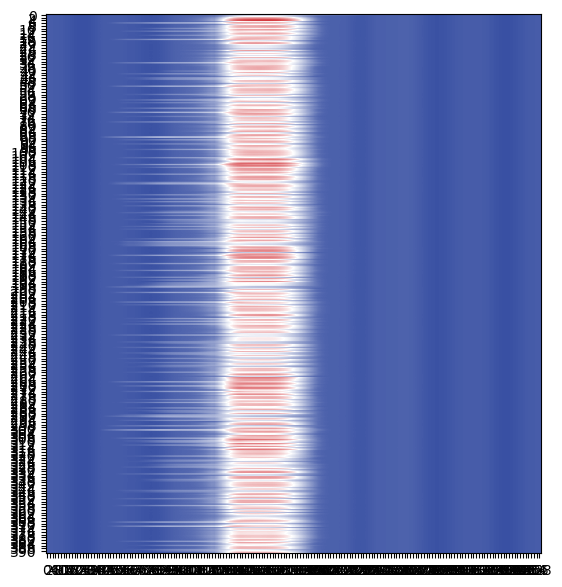

cyan_0


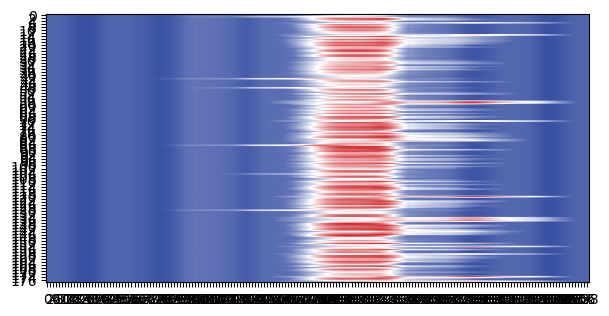

cyan_1


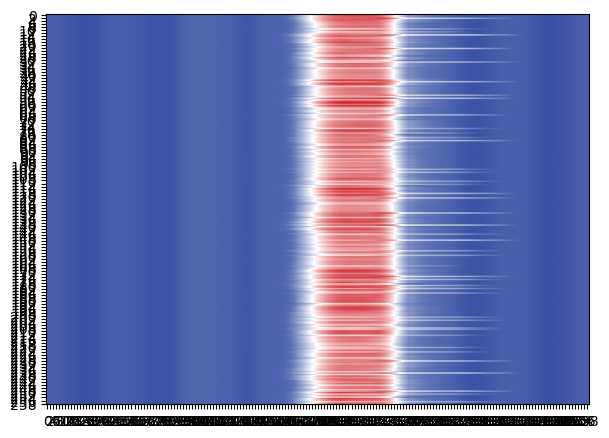

blue_0


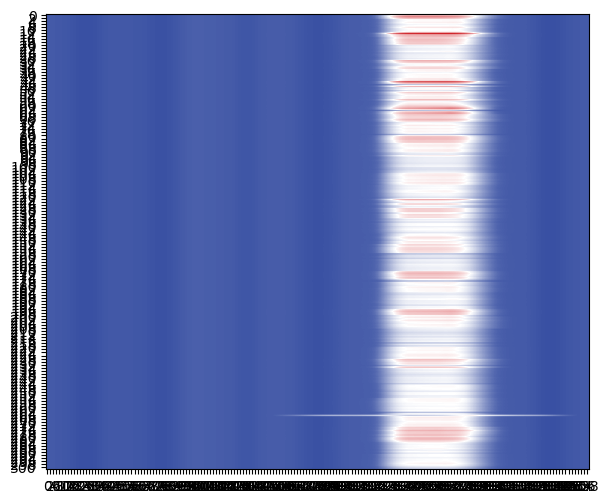

magenta_0


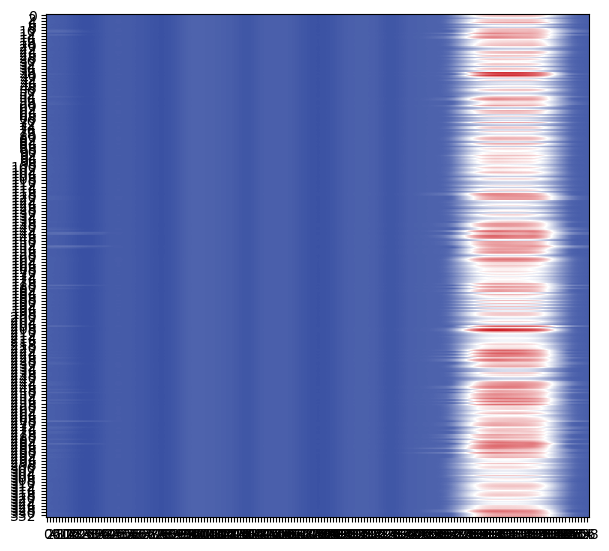

In [50]:
# for color in ["red", "orange", "yellow", "green", "cyan", "blue", "magenta", "white", "silver"]:
for color in color_labels:
    keys = []
    for key in label_color_dict.keys():
        if color in key:
            keys.append(key)
    for key in keys:
        print(key)
        plot_matrix(F_z_exc[np.where(labels_exc == label_color_dict[key])[0],:])

In [51]:
for i in (np.unique(labels_exc)):
    print(i, ", inputs")
    print(np.round(np.median(exc_inputs[np.where(labels_exc == i)[0]], axis = 0),3))
    
for i in (np.unique(labels_exc)):
    print(i, ", outputs")
    print(np.round(np.median(exc_outputs[np.where(labels_exc == i)[0]], axis = 0),3))

0 , inputs
[0.102 0.    0.   ]
1 , inputs
[0.    0.148 0.   ]
2 , inputs
[0.087 0.032 0.   ]
3 , inputs
[0.  0.  0.1]
4 , inputs
[0.131 0.    0.09 ]
5 , inputs
[0.   0.   0.16]
6 , inputs
[0.207 0.    0.   ]
7 , inputs
[0.    0.171 0.   ]
8 , inputs
[0.143 0.087 0.   ]
9 , inputs
[0. 0. 0.]
10 , inputs
[0.    0.    0.154]
0 , outputs
[0.35 0.   0.   0.   0.   0.   0.  ]
1 , outputs
[0.    0.    0.    0.405 0.    0.    0.   ]
2 , outputs
[0.    0.144 0.    0.    0.    0.    0.   ]
3 , outputs
[0.    0.    0.    0.    0.193 0.    0.   ]
4 , outputs
[0.    0.    0.    0.    0.    0.    0.392]
5 , outputs
[0.  0.  0.  0.  0.  0.4 0. ]
6 , outputs
[0.022 0.    0.    0.    0.    0.    0.005]
7 , outputs
[0.    0.    0.433 0.    0.    0.    0.   ]
8 , outputs
[0.    0.429 0.    0.    0.    0.    0.   ]
9 , outputs
[0. 0. 0. 0. 0. 0. 0.]
10 , outputs
[0.   0.   0.   0.   0.46 0.   0.  ]


red_0


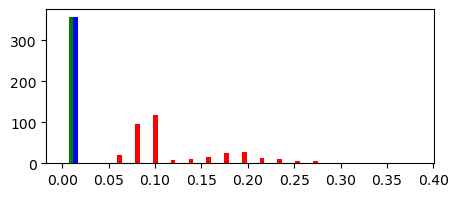

orange_0


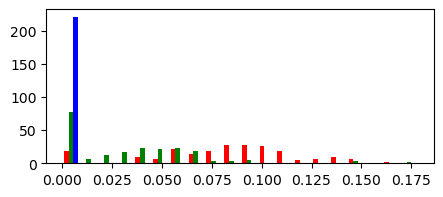

orange_1


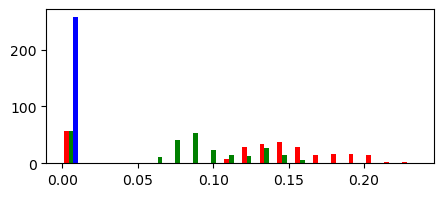

yellow_0


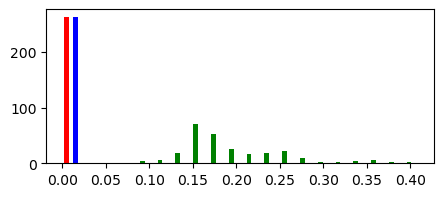

green_0


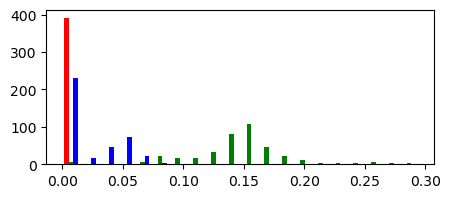

cyan_0


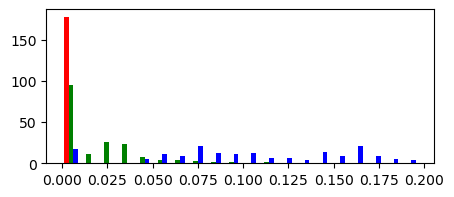

cyan_1


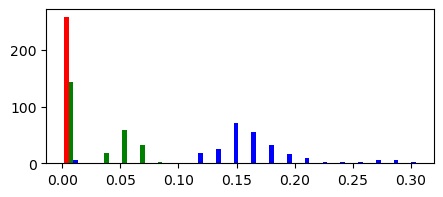

blue_0


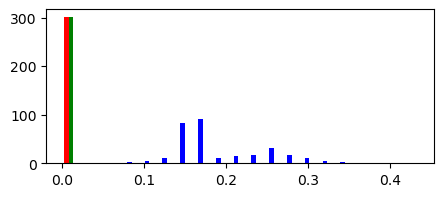

magenta_0


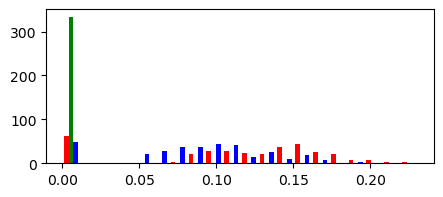

In [52]:
# for color in ["red", "orange", "yellow", "green", "cyan", "blue", "magenta", "white", "silver"]:
for color in colors:
    keys = []
    for key in label_color_dict.keys():
        if color in key:
            keys.append(key)
    for key in keys:
        print(key)
        arr = exc_inputs[np.where(labels_exc == label_color_dict[key])[0]]
        fig_hist, ax = plt.subplots(1, 1, figsize = (5, 2))
        plt.hist(arr, bins = 20, color=['r', 'g', 'b'])
        plt.show()

***Thus there are 8 definitive clusters of excitatory neurons:
7 of them provide an output to a corresponding color
the 8th cluster of neurons seems to be active only when either (magenta, red, orange) color is present***

right now, the input neurons receive input from one cone. How would the circuitry change if I remove the constraint?

In [53]:
# colors = ["red", "orange", "yellow", "green", "cyan", "blue", "magenta", "white", "silver"]
order = []
for color in colors:
    keys = label_color_dict.keys()
    for key in keys:
        if color in key:
            order.extend(np.where(labels_exc == label_color_dict[key])[0])
    
for i in np.unique(labels_inh):
    order.extend(np.where(labels_inh == i)[0])

In [54]:
labels_exc_ = deepcopy(labels_exc)
labels_inh_ = deepcopy(labels_inh)
data_dict = {}
for subdir in subdirs:
    if subdir == '.DS_Store':
        pass
    else:
        path_to_net = os.path.join(path, subdir)
        score = float(subdir.split("_")[0])
        config = json.load(open(os.path.join(path_to_net, f"{score}_config.json"), "rb+"))
        if config["lambda_smooth"] == lambda_smooth and config["lambda_orth"] == lambda_orth:
            net_params = json.load(open(os.path.join(path_to_net, f"{score}_params_ColorDiscrimination.json"), "rb+"))
            RNN = RNN_numpy(N=net_params["N"],
                                  dt=net_params["dt"],
                                  tau=net_params["tau"],
                                  activation=numpify(activation),
                                  W_inp=np.array(net_params["W_inp"]),
                                  W_rec=np.array(net_params["W_rec"]),
                                  W_out=np.array(net_params["W_out"]),
                                  bias_rec=net_params["bias_rec"],
                                  y_init=np.array(net_params["y_init"]))
            
            # need to classify neurons of this RNN somehow
            inh_ind = np.where(np.mean(RNN.W_rec, axis = 0) < 0)[0]
            exc_ind = np.where(np.mean(RNN.W_rec, axis = 0) >= 0)[0]
            #numberical labels of these neurons
            le = labels_exc_[:len(exc_ind)]
            li = labels_inh_[:len(inh_ind)]
            # convert the numerical labels to class-strings:
            cluster_labels = []
            for i in range(RNN.W_rec.shape[0]):
                # first find if this neuron is excitatory or inhibitory:
                if i in exc_ind:
                    # find the neuron position in this list:
                    j = list(exc_ind).index(i)
                    # get the numerical label
                    num_label = le[j]
                    # get the string label:
                    string_label = list(label_color_dict.keys())[num_label]
                if i in inh_ind:
                    # find the neuron position in this list:
                    j = list(inh_ind).index(i)
                    # get the numerical label
                    num_label = li[j]
                    string_label = f'inh_{num_label}'
                cluster_labels.append(string_label)
            
            labels_exc_ = labels_exc_[len(exc_ind):]
            labels_inh_ = labels_inh_[len(inh_ind):]
            data_dict[subdir] = cluster_labels

In [55]:
# data_dict[list(data_dict.keys())[0]]

In [56]:
classes = [key.split("_")[0] for key in list(label_color_dict.keys())]
classes.extend(classes_inh)
classes.remove("silver")
rec_connect_dict = {}
for cl1 in classes:
    for cl2 in classes:
        rec_connect_dict[(cl1, cl2)] = []
        
input_connect_dict = {}
for cl1 in classes:
    for i in range(W_inp.shape[1]):
        input_connect_dict[(cl1, i)] = []
        
output_connect_dict = {}
for cl1 in classes:
    for i in range(W_out.shape[0]):
        output_connect_dict[(i, cl1)] = []

NameError: name 'W_inp' is not defined

In [222]:
for subdir in subdirs:
    if subdir == '.DS_Store':
        pass
    else:
        path_to_net = os.path.join(path, subdir)
        score = float(subdir.split("_")[0])
        config = json.load(open(os.path.join(path_to_net, f"{score}_config.json"), "rb+"))
        if config["lambda_smooth"] == lambda_smooth and config["lambda_orth"] == lambda_orth:
            net_params = json.load(open(os.path.join(path_to_net, f"{score}_params_ColorDiscrimination.json"), "rb+"))
            W_rec = np.array(net_params["W_rec"])
            W_inp = np.array(net_params["W_inp"])
            W_out = np.array(net_params["W_out"])
            cluster_labels = data_dict[subdir]
            for i in range(W_rec.shape[0]):
                
                if "inh" in cluster_labels[i]:
                    cl_label_1 = cluster_labels[i]
                else:
                    cl_label_1 = cluster_labels[i].split("_")[0]
                if (cl_label_1 in classes):        
                    for j in range(W_rec.shape[1]):    
                        if "inh" in cluster_labels[j]:
                            cl_label_2 = cluster_labels[j]
                        else:
                            cl_label_2 = cluster_labels[j].split("_")[0]
                        if (cl_label_2 in classes):
                            try:
                                rec_connect_dict[(cl_label_1, cl_label_2)].append(W_rec[i, j])
                            except:
                                raise(KeyError(f"{cl_label_1}, {cl_label_2}"))
                    for j in range(W_inp.shape[1]):
                        input_connect_dict[(cl_label_1, j)].append(W_inp[i, j])
                    for j in range(W_out.shape[0]):
                        output_connect_dict[(j, cl_label_1)].append(W_out[j, i])

In [223]:
for i, cl1 in enumerate(classes):
    for j, cl2 in enumerate(classes):
        rec_connect_dict[(cl1, cl2)] = list(filter(lambda num: np.abs(num) >= 0.01, rec_connect_dict[(cl1, cl2)]))
        
for i, cl1 in enumerate(classes):
    for j in range(W_inp.shape[1]):
        input_connect_dict[(cl1, j)] = list(filter(lambda num: np.abs(num) >= 0.01, input_connect_dict[(cl1, j)]))
        
for i, cl1 in enumerate(classes):
    for j in range(W_out.shape[0]):
        output_connect_dict[(cl1, j)] = list(filter(lambda num: np.abs(num) >= 0.01, output_connect_dict[(j, cl1)]))

In [224]:
classes

['indigo',
 'green',
 'blue',
 'red',
 'orange',
 'amber',
 'chartreuse',
 'violet',
 'yellow',
 'cyan',
 'magenta',
 'vermillion',
 'inh_1',
 'inh_2',
 'inh_3',
 'inh_5',
 'inh_6',
 'inh_7']

In [226]:
# classes_reordered = ["white", "red", "orange", "yellow", "green", "cyan", "blue", "magenta"]
color_labels = ["red", "vermillion", "orange", "amber",
          "yellow", "chartreuse", "green", "cyan",
          "blue", "indigo", "violet", "magenta"]
classes_reordered = deepcopy(color_labels)
classes_reordered.extend(classes[-6:])
wr = np.zeros((len(classes_reordered), len(classes_reordered)))
wi = np.zeros((len(classes_reordered), 3))
wo = np.zeros((12, len(classes_reordered)))
for i, cl1 in enumerate(classes_reordered):
    for j, cl2 in enumerate(classes_reordered):
        if len(rec_connect_dict[(cl1, cl2)]) == 0:
            wr[i,j] = 0
        else:
            wr[i,j] = np.percentile(rec_connect_dict[(cl1, cl2)], 50)
            
for i, cl1 in enumerate(classes_reordered):
    for j in range(3):
        if len(input_connect_dict[(cl1, j)]) == 0:
            wi[i,j] = 0
        else:
            wi[i,j] = np.percentile(input_connect_dict[(cl1, j)], 50)
            
for i, cl1 in enumerate(classes_reordered):
    for j in range(12):
        if len(output_connect_dict[(j, cl1)]) == 0:
            wo[j,i] = 0
        else:
            wo[j, i] = np.percentile(output_connect_dict[(j, cl1)], 50)

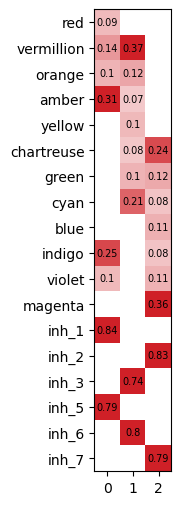

In [227]:
# input matrix
fig, ax = plt.subplots(1, 1, figsize = (6,6))
img = ax.imshow(wi, cmap=cmp, vmin = -0.3, vmax = 0.3)
for (i, j), z in np.ndenumerate(wi):
    if np.abs(z) > 0.02:
        ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k', fontsize=7)
ax.set_xticks(np.arange(wi.shape[1]))
ax.set_yticks(np.arange(len(classes_reordered)))
ax.set_yticklabels(classes_reordered)
plt.show()

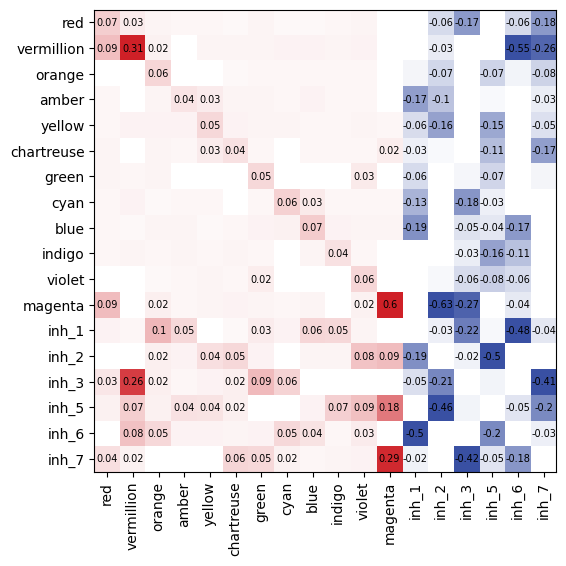

In [228]:
# recurrent matrix
fig, ax = plt.subplots(1, 1, figsize = (6,6))
img = ax.imshow(wr, cmap=cmp, vmin = -0.3, vmax = 0.3)
for (i, j), z in np.ndenumerate(wr):
    if np.abs(z) > 0.02:
        ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k', fontsize=7)
ax.set_xticks(np.arange(len(classes_reordered)))
ax.set_yticks(np.arange(len(classes_reordered)))
ax.set_xticklabels(classes_reordered, rotation=90)
ax.set_yticklabels(classes_reordered)
plt.show()

In [229]:
# output matrix
fig, ax = plt.subplots(1, 1, figsize = (6,6))
img = ax.imshow(wo, cmap=cmp, vmin = -0.3, vmax = 0.3)
for (i, j), z in np.ndenumerate(wo):
    if np.abs(z) > 0.02:
        ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k', fontsize=7)
ax.set_xticks(np.arange(len(classes_reordered)))
ax.set_yticks(np.arange(wo.shape[0]))
ax.set_xticklabels(classes_reordered, rotation=90)
plt.show()

In [230]:
# now, I need to come up with a template for latent circuit distillation
# W_rec initial
# W_out initial
# W_inp initial
# restrictions on input matrix and output matrix
# perhaps on the connectivity matrix as well

In [231]:
thr = 0.05
W_rec_thr = np.sign(wr) * (np.abs(wr) > thr) 
W_inp_thr = 1.0 * (np.abs(wi) > thr) 
W_out_thr = 1.0 * (np.abs(wo) > thr) 

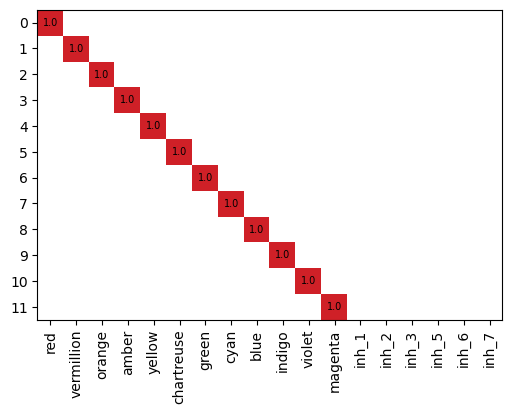

In [232]:
# output matrix
mat = W_out_thr
fig, ax = plt.subplots(1, 1, figsize = (6,6))
img = ax.imshow(mat, cmap=cmp, vmin = -0.3, vmax = 0.3)
for (i, j), z in np.ndenumerate(mat):
    if np.abs(z) > 0.02:
        ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k', fontsize=7)
ax.set_xticks(np.arange(len(classes_reordered)))
ax.set_yticks(np.arange(wo.shape[0]))
ax.set_xticklabels(classes_reordered, rotation=90)
plt.show()

In [233]:
print(repr(W_rec_thr))

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -1., -1.,  0., -1., -1.],
       [ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -0.,  0.,  0., -1., -1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,
        -1.,  0., -1., -0., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
        -1.,  0., -0.,  0., -0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
        -1.,  0., -1.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,
        -0.,  0., -1.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0., -1.,
         0., -0., -1.,  0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., -1.,
         0., -1., -0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0., -1.,
         0., -1., -0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,

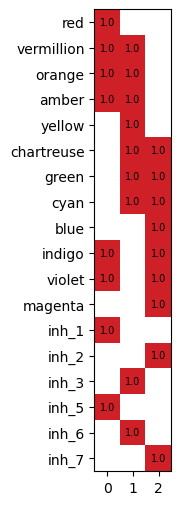

In [234]:
# input matrix
mat= W_inp_thr
fig, ax = plt.subplots(1, 1, figsize = (6,6))
img = ax.imshow(mat, cmap=cmp, vmin = -0.3, vmax = 0.3)
for (i, j), z in np.ndenumerate(mat):
    if np.abs(z) > 0.02:
        ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k', fontsize=7)
ax.set_xticks(np.arange(mat.shape[1]))
ax.set_yticks(np.arange(len(classes_reordered)))
ax.set_yticklabels(classes_reordered)
plt.show()

these matrices will be the latent circuit constraints!